# install dependancies

In [ ]:
! pip install datasets

# Imports

In [ ]:
import torch
import torch.nn as nn
import transformers
from huggingface_hub import notebook_login
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import random
import torch.nn.functional as F
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
notebook_login()

# Load Dataset

In [ ]:
dataset = load_dataset("ag_news")

In [ ]:
print(dataset)

## Get a subset aas the corpus

In [ ]:
corpus = dataset["train"]["text"][:5000]

# Build Tokenizer

In [ ]:
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()
trainer = WordLevelTrainer(vocab_size=5000, special_tokens=["[UNK]", "[PAD]"])

In [ ]:
tokenizer.train_from_iterator(corpus, trainer)

In [ ]:
output = tokenizer.encode(corpus[0])
print(output.tokens)
print(output.ids)

In [ ]:
tokenized_text = [tokenizer.encode(sentence).ids for sentence in corpus]

In [ ]:
print(tokenized_text[0])

In [ ]:
vocab = tokenizer.get_vocab()

# Get Skip-Gram Pairs

In [ ]:
def get_skip_gram_pairs(tokenized_text, window_size):
    pairs = []
    for sentence in tokenized_text:
        for i in range(len(sentence)):
            for j in range(max(0, i - window_size), min(len(sentence), i + window_size + 1)):
                if i != j:
                    pairs.append((sentence[i], sentence[j]))
    return pairs

In [ ]:
pairs = get_skip_gram_pairs(tokenized_text, 2)

In [ ]:
print(pairs[0:10])

# Skip-gram dataset

In [ ]:
class SkipGram_Data(Dataset):
  def __init__(self, pairs):
    self.pairs = pairs
  def __len__(self):
    return len(self.pairs)
  def __getitem__(self, idx):
    return torch.tensor(self.pairs[idx][0]), torch.tensor(self.pairs[idx][1])

## Get negative samples

In [ ]:
def sample_negative_words(batch_size, vocab_size, num_negatives, device, true_context):
    negative_samples = []
    for _ in range(batch_size):
        negatives = []
        while len(negatives) < num_negatives:
            rand_word = random.randint(0, vocab_size - 1)
            if rand_word != true_context[_].item():
                negatives.append(rand_word)
        negative_samples.extend(negatives)
    return torch.tensor(negative_samples, device=device)

# Model Class

In [ ]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.in_embed = nn.Embedding(vocab_size, embedding_dim)
        self.out_embed = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, center_words, context_words):
        center_embed = self.in_embed(center_words)
        context_embed = self.out_embed(context_words)
        scores = torch.sum(center_embed * context_embed, dim=1)
        return scores

    def get_embeddings(self):
        return self.in_embed.weight.data

# Initiate dataset

In [ ]:
train_dataset = SkipGram_Data(pairs)
dataloader = DataLoader(train_dataset, batch_size=4096, shuffle=True)

# Set device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training loop

In [ ]:
embedding_dim = 100
num_negatives = 5
vocab_size = len(vocab)

model = Word2Vec(vocab_size, embedding_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
for epoch in range(5):
    total_loss = 0
    dataloader_loop = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False)

    for center, pos_context in dataloader_loop:
        center = center.to(device)
        pos_context = pos_context.to(device)
        batch_size = center.size(0)

        pos_scores = model(center, pos_context)
        pos_labels = torch.ones_like(pos_scores)

        neg_context = sample_negative_words(batch_size, vocab_size, num_negatives, device, pos_context)
        neg_center = center.repeat_interleave(num_negatives)
        neg_scores = model(neg_center, neg_context)
        neg_labels = torch.zeros_like(neg_scores)

        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([pos_labels, neg_labels])
        loss = F.binary_cross_entropy_with_logits(scores, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        dataloader_loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}: Loss = {(total_loss/len(dataloader)):.4f}")

# Inference

In [ ]:
test_corpus = dataset["test"]["text"][:100]

In [ ]:
print(test_corpus[0])

In [ ]:
tokenized_test_text = [tokenizer.encode(sentence).ids for sentence in test_corpus]

In [ ]:
test_pairs = get_skip_gram_pairs(tokenized_test_text, 2)

In [ ]:
test_dataset = SkipGram_Data(test_pairs)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
with torch.inference_mode():
    total_loss = 0
    dataloader_loop = tqdm(test_dataloader, desc=f"test", leave=False)

    for center, pos_context in dataloader_loop:
        center = center.to(device)
        pos_context = pos_context.to(device)
        batch_size = center.size(0)

        pos_scores = model(center, pos_context)
        pos_labels = torch.ones_like(pos_scores)

        neg_context = sample_negative_words(batch_size, vocab_size, num_negatives, device, pos_context)
        neg_center = center.repeat_interleave(num_negatives)
        neg_scores = model(neg_center, neg_context)
        neg_labels = torch.zeros_like(neg_scores)

        scores = torch.cat([pos_scores, neg_scores])
        labels = torch.cat([pos_labels, neg_labels])
        loss = F.binary_cross_entropy_with_logits(scores, labels)

        total_loss += loss.item()
        dataloader_loop.set_postfix(loss=loss.item())
    print(f"Average Loss = {total_loss / len(test_dataloader):.4f}")

# Save Model

## Save the state dictionary

In [ ]:
torch.save(model.state_dict(), "word2vec_model_state_dict.pth")

## Save the entire model

In [ ]:
torch.save(model, "word2vec_full_model.pth")

# Visualization

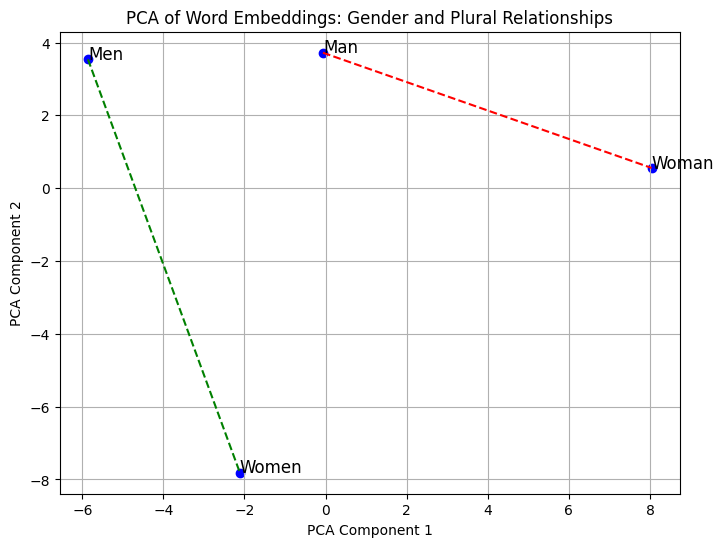

In [65]:
man = model.get_embeddings()[vocab["man"]].cpu().detach().numpy()
woman = model.get_embeddings()[vocab["woman"]].cpu().detach().numpy()
men = model.get_embeddings()[vocab["men"]].cpu().detach().numpy()
women = model.get_embeddings()[vocab["women"]].cpu().detach().numpy()

words = np.array([man, woman, men, women])
labels = ['Man', 'Woman', 'Men', 'Women']

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(words)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue')

for i, label in enumerate(labels):
    plt.annotate(label, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=12)


plt.plot([reduced_embeddings[0, 0], reduced_embeddings[1, 0]],
         [reduced_embeddings[0, 1], reduced_embeddings[1, 1]], 'r--')
plt.plot([reduced_embeddings[2, 0], reduced_embeddings[3, 0]],
         [reduced_embeddings[2, 1], reduced_embeddings[3, 1]], 'g--')

plt.title("PCA of Word Embeddings: Gender and Plural Relationships")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()